# BME-1301 Lab-1: Construct your CNN for MRI reconstruction

In [2]:
######################## WRITE YOUR ANSWER BELOW ########################
STUDENT_NAME = 'Example'
STUDENT_NUMBER = '1234567890'
#########################################################################

In [3]:
%load_ext autoreload
%autoreload 2

## Setup environments
You are required to install the following packages.
- jupyter
- scikit-image
- numPy
- pytorch torchvision
- matplotlib
- tqdm

In [4]:
# necessary packages for this homework, you are free to import more.
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import functional as F
from torchvision import transforms

# packages of this lab
from bme1301 import lab1 as lab

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Importation successful.')

Importation successful.


## Part 1: Warm up
In part-1, you will learn the basic operations to complete the deep learning MRI reconstruction using PyTorch and NumPy. You can skip this part if you are already familiar with the topics.  

Some learning materials:
- [NumPy: the absolute basics for beginners](https://numpy.org/doc/1.22/user/absolute_beginners.html)
- [PyTorch Official Tutorials](https://pytorch.org/tutorials/)

Official documents of NumPy and PyTorch:
- [NumPy API Reference](https://numpy.org/doc/1.22/reference/index.html#reference)
- [PyTorch API Reference](https://pytorch.org/docs/stable/index.html)


### Part 1A: Tensor/ndarray Operations
In this section, you are required to be capable of manipulating mult-dimensions array, i.e. `numpy.ndarray` in NumPy and `torch.Tensor` in PyTorch. Most operations of ndarray and tensor are similar, you can find PyTorch tensor's API once you understand the usage of `ndarray` in numpy.

Learning material:
- [图解Python numpy基本操作 - 知乎](https://zhuanlan.zhihu.com/p/396444973)

#### Numpy ndarray

Min-Max: 
$$
x_i' = \frac{x_i - x_\mathrm{min}}{x_\mathrm{max} - x_\mathrm{min}}
$$

Standard Normalization: 
$$
x_i' = \frac{x_i - \mathrm{mean}(X)}{\mathrm{std}(X)}
$$

In [5]:
# generate random image by normal distribution
def random_image():
    ######################## WRITE YOUR ANSWER BELOW ########################
    return np.random.rand(1,256,256)
    pass
    #########################################################################

x = random_image()
assert x.shape == (1, 256, 256)

In [6]:
# Min-Max Normalization
x = random_image()
######################## WRITE YOUR ANSWER BELOW ########################
 
x = (x-x.min())/(x.max()-x.min())
########################################################################
assert np.abs(x.min()) < 1e-8
assert np.abs(x.max() - 1.0) < 1e-8

# standard normalization
x = random_image()
######################## WRITE YOUR ANSWER BELOW ########################
x=(x-np.mean(x))/np.std(x)

########################################################################
 
assert np.abs(np.mean(x)) < 1e-8
assert np.abs(np.std(x) - 1.0) < 1e-8

In [7]:
# Concatenate and Stack on the axis-0
x1 = random_image()
x2 = random_image()
######################## WRITE YOUR ANSWER BELOW ########################
 
x_concate = np.concatenate((x1,x2),axis=0)
x_stack = np.stack((x1,x2),axis=0)
########################################################################
assert x_concate.shape == (2, 256, 256) 
assert x_stack.shape == (2, 1, 256, 256) 

In [8]:
# Swap row-1 and row-2 of x in one line. Hint: fancy indexing, array[[]]
x = np.arange(4).reshape(2, 2)
######################## WRITE YOUR ANSWER BELOW ########################
x=[x[1],x[0]]
pass
########################################################################
assert np.all(x == np.array([
    [2, 3], 
    [0, 1]
    ]))


#### PyTorch tensor
Try the same tasks in PyTorch's `Tensor`.

In [9]:
# generate random image by normal distribution
def random_image():
    ######################## WRITE YOUR ANSWER BELOW ########################
    return torch.rand(1,256,256)
    pass
    ########################################################################

x = random_image()
assert x.shape == (1, 256, 256)
assert isinstance(x, torch.Tensor)

# Min-Max Normalization
x = random_image()
######################## WRITE YOUR ANSWER BELOW ########################
x = (x-x.min())/(x.max()-x.min())
########################################################################
assert torch.abs(x.min()) < 1e-5
assert torch.abs(x.max() - 1.0) < 1e-5

# standard normalization
x = random_image()
######################## WRITE YOUR ANSWER BELOW ########################
x=(x-torch.mean(x))/torch.std(x)
########################################################################
assert torch.abs(torch.mean(x)) < 1e-5
assert torch.abs(torch.std(x) - 1.0) < 1e-5

# Concatenate and Stack on the axis-0
x1 = random_image()
x2 = random_image()
# print(x1.shape)
######################## WRITE YOUR ANSWER BELOW ########################
x_concate = torch.cat((x1,x2),axis=0)
x_stack = torch.stack((x1,x2),axis=0)
########################################################################
assert x_concate.shape == (2, 256, 256) 
assert x_stack.shape == (2, 1, 256, 256) 

# Swap row-1 and row-2 of x in one line
x = torch.arange(4).reshape(2, 2)
# print(x)
######################## WRITE YOUR ANSWER BELOW ########################
x[[0, 1]] = x[[1,0]]
########################################################################
assert torch.all((x - torch.tensor([[2, 3], [0, 1]])) < 1e-5)

### Part 1B: Train MLP in PyTorch
In this section, you will learn the basic pipeline of training a network in PyTorch. 
1. Define your model
2. Perform the forward propagation 
3. Perform the backward propagation, then optimize by one step based on the gradients

In [12]:
def one_optimize_step(inputs, ground_truth, model, criterion, optimizer):
    # forward propagation. Hint: feed batch into the network
    ######################## WRITE YOUR ANSWER BELOW ########################
    y_pred=model(inputs)
    pass
    ########################################################################

    # backward. Hint: compute loss, clear the gradients, perform backward propagation
    ######################## WRITE YOUR ANSWER BELOW ########################
    loss = criterion(y_pred,ground_truth)
    optimizer.zero_grad()
    loss.backward()
    pass
    ########################################################################

    # optimize. Hint: .step() function
    ######################## WRITE YOUR ANSWER BELOW ########################
    optimizer.step()
    pass
    ########################################################################

    return loss

# Test your optimize_step
model = nn.Linear(1, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
x = torch.arange(0, 10, step=0.01).reshape(-1, 1)  # [N_batch, 1]
y = torch.sin(x).reshape(-1, 1)  # [N_batch, 1]
loss = one_optimize_step(x, y, model, criterion, optimizer)
print(loss)

tensor(10.8908, grad_fn=<MseLossBackward0>)


In [5]:
import numpy as np
x=np.arange(0,3,1).reshape(-1,1)
print(x.shape)
y=np.sin(x)
print(y.shape)

(3, 1)
(3, 1)


Loss in epoch-010: 1.56e-01
Loss in epoch-020: 4.09e-02
Loss in epoch-030: 1.44e-02
Loss in epoch-040: 4.06e-03
Loss in epoch-050: 2.56e-03
Loss in epoch-060: 1.35e-03
Loss in epoch-070: 8.70e-04
Loss in epoch-080: 1.60e-03
Loss in epoch-090: 4.75e-04
Loss in epoch-100: 7.06e-04


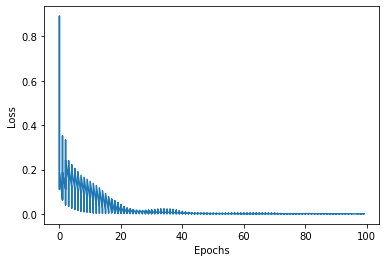

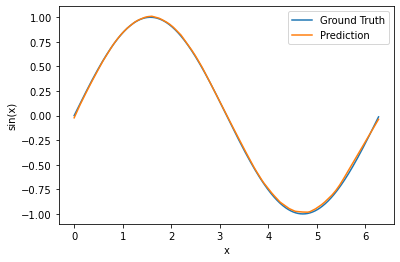

In [10]:
# Fit y=sin(x) using MLP, tune training paramter to get a plausible result
# We encourage you to tune the learning rate exponentially. For example, you can try 0.1, 0.01, 0.001, 0.0001, 0.00001
LEARNING_RATE = 0.001
BATCH_SIZE = 20  # range from 0~1000

model = nn.Sequential(
    nn.Linear(1, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=1e-6
    )

# Example Data for training
x = np.arange(0, 6.28, step=0.01).reshape(-1, 1)  # [N_batch, 1] 
y = np.sin(x).reshape(-1, 1)  # [N_batch, 1]
NUM_DATA_POINTS = x.shape[0]

# We always shuffle the data when the stochasitc gradient descend is used
shuffle_indices = np.arange(0, NUM_DATA_POINTS)
np.random.shuffle(shuffle_indices)
x_shuffled = torch.tensor(x[shuffle_indices], dtype=torch.float32)
y_shuffled = torch.tensor(y[shuffle_indices], dtype=torch.float32)

NUM_EPOCHS = 100
LOG_STEP = 10

# Training loop, optimization steps are performed by multiple times.
epoch_list = []
loss_list = []
for epoch in range(NUM_EPOCHS):
    for start_idx in range(0, NUM_DATA_POINTS, BATCH_SIZE):
        # Fetch part of whole dataset
        x_batch = x_shuffled[start_idx:start_idx + BATCH_SIZE]
        y_batch = y_shuffled[start_idx:start_idx + BATCH_SIZE]
        ######################## WRITE YOUR ANSWER BELOW ########################
        loss = None
        ########################################################################
        loss_value = loss.item()  # Conver pytorch tensor into python number
        epoch_list.append(epoch) #1 1 1 1 1 1 1 1... 1*NUM_DATA_POINTS
        loss_list.append(loss_value)
    if (epoch+1) % LOG_STEP == 0 or epoch == NUM_EPOCHS-1:
        print(
            f"Loss in epoch-{epoch + 1:#0{len(str(NUM_EPOCHS))}d}: {loss_value:.2e}")

# Show losses
plt.figure()
plt.plot(epoch_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# plot the prediction and the ground truth
y_pred = model(torch.tensor(x, dtype=torch.float32)).detach().numpy()
plt.figure()
plt.plot(x, y, label='Ground Truth')
plt.plot(x, y_pred, label='Prediction')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

plt.close('all')


What is your conclusion for tunning the learning rate?

$\large \color{#a30b19}{Answer:}$

## Part 2: Understand MRI data
### Part 2A: Data loading
Here a subset of fastMRI single coil dataset is provided. There are 1000 complex-valued images for you to perform MRI reconstruction. We already preprocessed the dataset by center croped (256x256) and normalization.

Here are some examples: 
![dataset](./assets/selected_1000_illustration.png)

In [11]:
knee_dataset = lab.FastmriKnee(path='./data/knee_singlecoil_1000.npz')

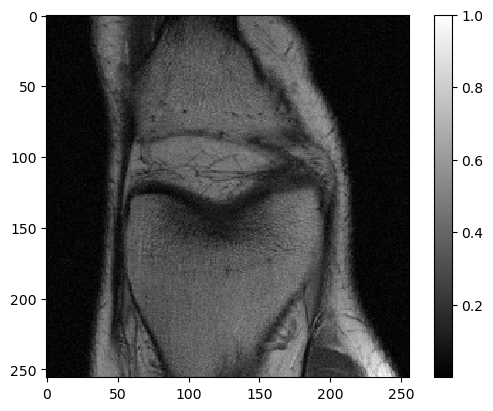

In [12]:
# helper function: Visualize a sample
def visualize_data_point(data_point):
    im_gt = data_point
    img = lab.pseudo2real(im_gt)
    lab.imgshow(img)

# Try different index range in [0, 1000) to see different images in dataset.
index = 270
visualize_data_point(knee_dataset[index])

### Part 2B: MRI cartesian undersample
In order to acclerate MRI acquisition, it is common to perform undersample accleration. Here we simulate cartesian undersampling strategy. We implemented undersampling functionality in dataset object. The return values of our dataset is:
1. The undersampled kspace.
2. Undersampling pattern.
3. Fully sampled image.

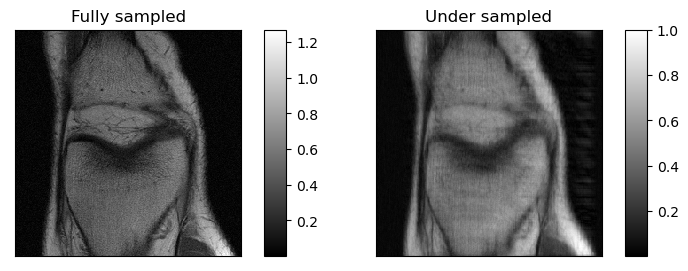

In [13]:
dataset = lab.DatasetReconMRI(dataset=knee_dataset)


def helper_show_data_point(data_point):
    k_und, und_mask, im_gt = data_point
    img_und = np.abs(lab.kspace2image(lab.pseudo2complex(k_und)))
    img_gt = lab.pseudo2real(im_gt)
    lab.imsshow([img_gt, img_und], titles=[
                'Fully sampled', 'Under sampled'], is_colorbar=True)


# Try different index range in [0, 1000) to see different images in dataset.
index = 270
helper_show_data_point(dataset[index])


**Task of acclerated MRI reconstruction**: reconstruct undersampled kspace (corresponding to *under sampled*) data into images as close to fully sampled as possible. Describle what you have observed in the comparision.

$\large \color{#a30b19}{Answer:}$

### Part 2C: Prepare dataset loaders
Three data loaders will be used in the following training, validation and testing phases. Most of codes are provided, you need to understand the usage of `torch.utils.data.DataLoader` and build `val_loader` and `test_loader` by yourself.

In [14]:
TRAIN_INDICES = np.arange(0, 600)
TEST_INDICES = np.arange(600, 800)
VAL_INDICES = np.arange(800, 1000)


def build_loaders(dataset, train_indices, val_indices, test_indices, batch_size=10, train_augment_fn=None, num_workers=4):
    train_subset, val_subset, test_subset = lab.split_dataset(
        dataset=knee_dataset, indices_list=[
            train_indices, val_indices, test_indices]
    )

    train_dataset = lab.DatasetReconMRI(train_subset, augment_fn=train_augment_fn)
    val_dataset = lab.DatasetReconMRI(val_subset)
    test_dataset = lab.DatasetReconMRI(test_subset)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
    ######################## WRITE YOUR ANSWER BELOW ########################
    val_loader = None
    test_loader = None
    ########################################################################

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = build_loaders(
    knee_dataset, TRAIN_INDICES, VAL_INDICES, TEST_INDICES,
    batch_size=5  # Reduce this number if your computer does not has large gpu vram
)
print(f"Number of batches for train/val/test: {len(train_loader)}/{len(val_loader)}/{len(test_loader)}")


Number of batches for train/val/test: 120/40/40


## Part 3: Build your CNN

### Part 3A: Base framework
We will perform MRI reconstruion from undersampled raw data in kspace. A framework is already provided to process kspace MRI data into images space. Yo need to pass a CNN instance as the argument `recon_net` into the framework in order to make it usable.

The initial input `k_und` is a pseudo-complex* kspace data, which is converted to pseudo-complex image by the following steps:
1. Convert `(2, H, W) pseudo-complex` data into `(H, W) complex`
2. Perform ifft on `(H, W) complex`, we transform the kspace into image space
3. Convert `(H, W) complex` image into `(2, H, W) pseudo-complex` image


\* pseudo-complex: a method for representing complex data in `float` data type. Two channels are used to represent real and imaginary part. Eg. a pseudo-complex image can be represented in the dimensions of `(2, H, W)`.

<center>
<img src="./assets/framework.png" width=600pt>
</center>

In [15]:
class MRIReconstructionFramework(nn.Module):
    def __init__(self, recon_net: nn.Module):
        super().__init__()
        self.recon_net = recon_net

    def forward(self, k_und, mask):
        B, C, H, W = k_und.shape
        assert C == 2
        assert (B, H, W) == tuple(mask.shape)
        
        im_und = lab.complex2pseudo(lab.kspace2image(lab.pseudo2complex(k_und)))
        ######################## WRITE YOUR ANSWER BELOW ########################
        im_recon = None
        ########################################################################
        return im_recon


### Part 3B: Define a simple CNN
Use the knowledge you learned from this course to build a simple CNN. We already define necessary components for you, all you need is complete the `forward` function.

A schematic illustration of the network you need to implement:

<center>
<img src="./assets/5-layer-cnn.png" width=600pt>
</center>

In [16]:
# Network definition
class MultiLayerCNN(nn.Module):
    def __init__(self, n_hidden=64):
        super().__init__()
        self.conv1 = nn.Conv2d(2, n_hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(n_hidden, 2, kernel_size=3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, im_und):
        """
        - im_und: tensor[B, C=2, H, W]
        """
        ######################## WRITE YOUR ANSWER BELOW ########################
        im_recon = None
        #########################################################################
        return im_recon


# test a forward
im_mock = torch.randn(1, 2, 256, 256)
net = MultiLayerCNN()
out = net(im_mock)
print(out.shape)
assert (1, 2, 256, 256) == tuple(out.shape)


torch.Size([1, 2, 256, 256])


### Part 3C: Define your Loss function
Implement a Mean-Squared-Error function. $y$ is the fully-sampled MRI images, which is ground truth. $x$ is your CNN's reconstruciton. $N$ is the number of pixels in each image.
$$
L_\text{mse} = \frac{1}{N} \sum_{i=1}^N{\left \| y_i - x_i \right \|^2}, \quad i = 1, \cdots, N
$$

In [17]:
class MSELoss():
    def __call__(self, im_recon, im_gt):
        """
        - im_recon: tensor[B, C=2, H, W]
        - im_gt: tensor[B, C=2, H, W]
        """
        B, C, H, W = im_recon.shape
        x = lab.pseudo2real(im_recon)  # [B, H, W]
        y = lab.pseudo2real(im_gt)     # [B, H, W]
        ######################## WRITE YOUR ANSWER BELOW ########################
        loss = None
        #########################################################################
        return loss


# test for loss computation
mse = MSELoss()
x_mock = torch.randn(1, 2, 256, 256)
y_mock = torch.randn(1, 2, 256, 256)
assert mse(x_mock, y_mock) >= 0


### Part 3D: Train the CNN

In part-1B, you implemented a simple framework of PyTorch training and validation. To train a MRI reconstruction network, the framework is much more complicated. We want you to focus on the model and learn the basic intuitions of deep learning MRI reconstruction, thus the boilerplates are provide for you to perform training/validation/visualiztion interactivly, wraped in `lab.Solver` class.  

  0%|          | 0/600 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

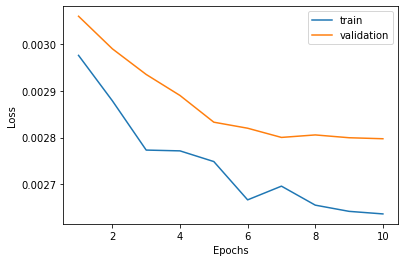

[Validation]:   0%|          | 0/200 [00:00<?, ?img/s]

============================== Measurements==============================
[avg_PSNR] 25.496530265808104
[avg_SSIM] 0.7814018709301328


In [18]:
# Define network
net = MRIReconstructionFramework(
    ######################## WRITE YOUR ANSWER BELOW ########################
    recon_net=None
    #########################################################################
)

# Training & Validation
solver = lab.Solver(
    model=net,
    optimizer=torch.optim.Adam(
        net.parameters(),
        lr=0.0001
    ),
    criterion=MSELoss()
)

epochs_to_train = 10
solver.train(epochs_to_train, train_loader, val_loader=val_loader)
solver.validate(test_loader)

### Part 3E: Visualize

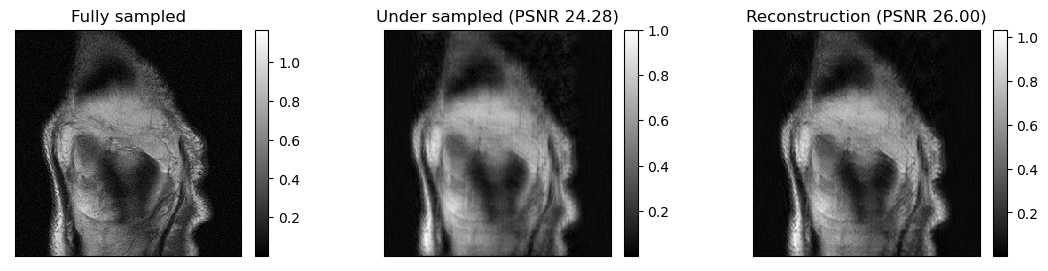

In [19]:
# changing data_index to see diffferent sample's visualization
data_index = 100  # range in [0, 200)
solver.visualize(test_loader, data_index, dpi=100)

Describle what you have observed in the comparision.

$\large \color{#a30b19}{Answer:}$

# Part 4: Techniques to make your CNN stronger

### Part 4A: Cascade Network
Cascade network is a method frequently used in MRI reconstruction. In this section you will change your network into a cascaded style. The cascade framework and its data consistency layer are already implemented, you need to embed your network into the framework by passing your network instance through argument `recon_net` and specify the number of cascades. 

Schematic illustration of network architecture, adopted from:
> Schlemper, Jo, Jose Caballero, Joseph V. Hajnal, Anthony Price, and Daniel Rueckert. 2017. “A Deep Cascade of Convolutional Neural Networks for MR Image Reconstruction.” In International Conference on Information Processing in Medical Imaging, 647–58. Springer.

<center>
<img src="./assets/dccnn.png" width=600pt>
</center>

In [20]:
class CascadeMRIReconstructionFramework(nn.Module):
    def __init__(self, recon_net: nn.Module, n_cascade: int):
        super().__init__()
        self.recon_net = recon_net
        self.n_cascade = n_cascade

        assert n_cascade > 0
        dc_layers = [lab.DataConsistencyLayer() for _ in range(n_cascade)]
        self.dc_layers = nn.ModuleList(dc_layers)

    def forward(self, k_und, mask):
        B, C, H, W = k_und.shape
        assert C == 2
        assert (B, H, W) == tuple(mask.shape)

        im_und = lab.complex2pseudo(lab.kspace2image(lab.pseudo2complex(k_und)))
        im_recon = im_und
        for dc_layer in self.dc_layers:
            im_recon = self.recon_net(im_recon)
            im_recon = dc_layer(im_recon, k_und, mask)
        return im_recon

In [21]:
# Define network
net = CascadeMRIReconstructionFramework(
    ######################## WRITE YOUR ANSWER BELOW ########################
    recon_net=None,
    #########################################################################
    n_cascade=5
)

# test a forward
im_mock = torch.randn(1, 2, 256, 256)
mask_mock = torch.randn(1, 256, 256)
out = net(im_mock, mask_mock)
print(out.shape)
assert (1, 2, 256, 256) == tuple(out.shape)

torch.Size([1, 2, 256, 256])


  0%|          | 0/600 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

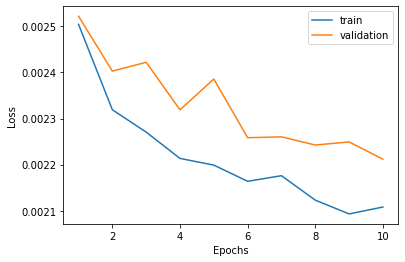

[Validation]:   0%|          | 0/200 [00:00<?, ?img/s]

============================== Measurements==============================
[avg_PSNR] 27.35623151779175
[avg_SSIM] 0.8091879883934153


In [22]:
# Training & Validation
solver = lab.Solver(
    model=net,
    optimizer=torch.optim.Adam(
        net.parameters(),
        lr=0.0001
    ),
    criterion=MSELoss()
)

epochs_to_train = 10
solver.train(epochs_to_train, train_loader, val_loader=val_loader)
solver.validate(test_loader)


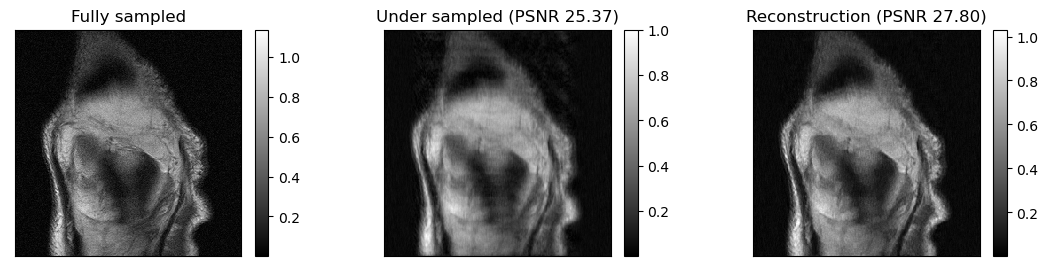

In [23]:
solver.visualize(test_loader, idx=100)

### Part 4B: Dropout.

Dropout is a commonly used techniques to reduce overfitting. We will modify the simple CNN by adding 2D Dropout layer into the network. Like `ReLU` in PyTorch, `Dropout2d` is a parameter-free layer, we can instantiate once and use it multiple times. You may find more detail about it in [PyTorch's document of Dropout2d]( https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html ).

A schematic illustration of the network you need to implement.

<center>
<img src="./assets/5-layer-cnn-dropout.png" width=600pt>
</center>

In [24]:
# Network building
class CNN_Regularized(nn.Module):
    def __init__(self, n_hidden=64):
        super().__init__()
        ######################## WRITE YOUR ANSWER HERE ########################
        pass
        ########################################################################
        self.drop = nn.Dropout2d(p=0.1)

    def forward(self, im_und):
        """
        - im_und: tensor[B, C=2, H, W]
        """
        ######################## WRITE YOUR ANSWER HERE ########################
        pass
        im_recon = None
        ########################################################################
        return im_recon


# test a forward
im_mock = torch.randn(1, 2, 256, 256)
net = CNN_Regularized()
out = net(im_mock)
print(out.shape)
assert (1, 2, 256, 256) == tuple(out.shape)

torch.Size([1, 2, 256, 256])


### Part 4C: Data Augmentation

*Data augmentation* is a method to overcome the scarcity of datasets. We can generate many augmented images from orgiginal dataset by modifying their intensities, locations or even shapes. In this section, you will learn how to implement data agumentation in PyTorch.

We leave a hook in the dataset class, which makes it possible for you to integrate a augmentation transform into the data generation process. You will implement a PyTorch transform object, and insert it into the dataset.

Two helper functions are given:
1. `torch.Tensor` is the primary type for PyTorch transforms and network's computation, while `np.ndarray` is the type inside our dataset, which is commonly used in the data preprocessing. That is why we need `compose_torch_augmentation` to manage the type casting between `np.ndarray` and `torch.Tensor`.
2. `helper_show_transform` will help you to visualize the augmented image and the original image.

In [25]:
def compose_torch_augmentation(augmentations: list):
    augmentations.insert(0, transforms.Lambda(lambda x: torch.tensor(x)))
    augmentations.append(transforms.Lambda(lambda x: x.numpy()))
    return transforms.Compose(augmentations)

def helper_show_transform(data_point, transform):
    im_gt = data_point
    im_aug = transform(im_gt)
    im_gt = lab.pseudo2real(im_gt)
    im_aug = lab.pseudo2real(im_aug)
    lab.imsshow([im_gt, im_aug], titles=[
                'Fully sampled', 'Transformed'], is_colorbar=True)

We implemented `affine_transform` for you as an example, you will implement the following transforms by yourself.

Hint: [Transforming and augmenting images — Torchvision 0.12 documentation]( https://pytorch.org/vision/stable/transforms.html )

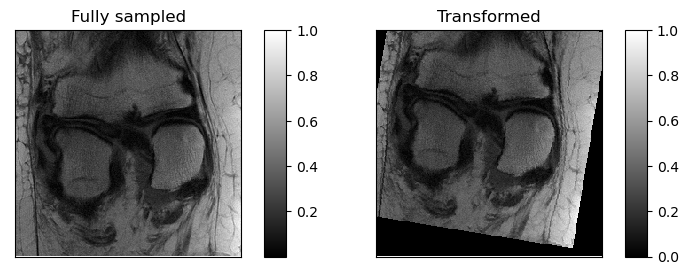

In [26]:
affine_transform = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))
# Test
composed_transform = compose_torch_augmentation([affine_transform])

# Visualize
helper_show_transform(knee_dataset[100], composed_transform)

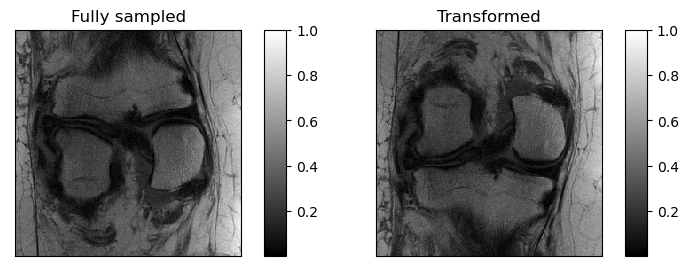

In [27]:
######################## WRITE YOUR ANSWER BELOW ########################
vertical_flip_transform = None
#########################################################################
composed_transform = compose_torch_augmentation([vertical_flip_transform])

# Visualize
helper_show_transform(knee_dataset[100], composed_transform)

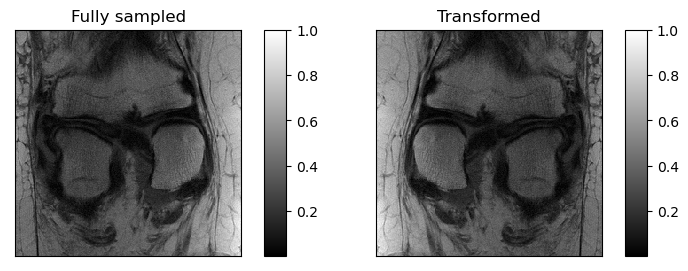

In [28]:
######################## WRITE YOUR ANSWER BELOW ########################
horizontal_flip_transform = None
#########################################################################
composed_transform = compose_torch_augmentation([horizontal_flip_transform])

# Visualize
helper_show_transform(knee_dataset[100], composed_transform)

You may perform your own transform function beside the pre-define transformations in PyTorch. A wrapper named `transforms.Lambda()` can be used to handle this job.

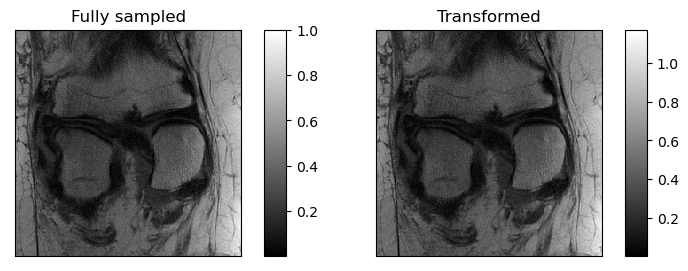

In [29]:
def intensity_variation(im):
    ratio = torch.clip(torch.randn(1), min=-3, max=3) * 0.1 + 1
    return im * ratio


######################## WRITE YOUR ANSWER BELOW ########################
# use `transforms.Lambda` to wrap `intensity_variation` function.
intensity_variation_transform = None
#########################################################################
composed_transform = compose_torch_augmentation([intensity_variation_transform])

# Visualize
helper_show_transform(knee_dataset[100], composed_transform)

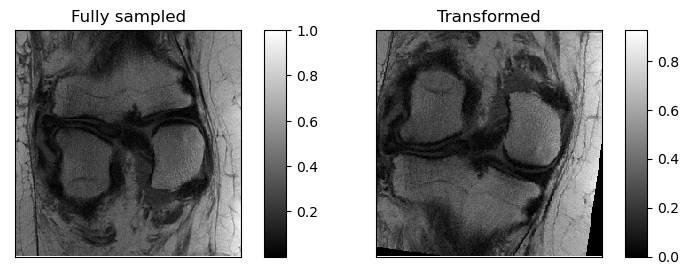

In [30]:
aug_transform=compose_torch_augmentation([
    affine_transform,
    vertical_flip_transform,
    horizontal_flip_transform,
    intensity_variation_transform
])

# Visualize
helper_show_transform(knee_dataset[100], aug_transform)


Now, insert the composed transformations `aug_transform` into the data generation process. Simply pass it to the argument `train_augment_fn` in `build_loaders`.

In [31]:
TRAIN_INDICES = np.arange(0, 600)
TEST_INDICES = np.arange(600, 800)
VAL_INDICES = np.arange(800, 1000)

train_loader, val_loader, test_loader = build_loaders(
    knee_dataset, TRAIN_INDICES, VAL_INDICES, TEST_INDICES,
    ######################## WRITE YOUR ANSWER BELOW ########################
    train_augment_fn=None,
    #########################################################################
    batch_size=5  # Reduce this number if your computer does not has large gpu vram
)
print(f"Number of batches for train/val/test: {len(train_loader)}/{len(val_loader)}/{len(test_loader)}")

Number of batches for train/val/test: 120/40/40


### Part 4D: Complete training
Train the regularized network with data augmentation strategies in 100 epochs.

  0%|          | 0/600 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

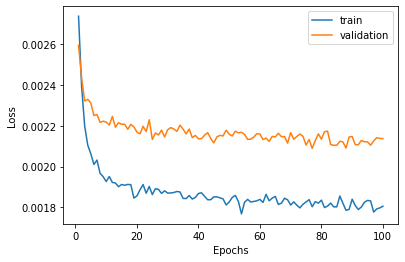

[Validation]:   0%|          | 0/200 [00:00<?, ?img/s]

============================== Measurements==============================
[avg_PSNR] 27.536939001083375
[avg_SSIM] 0.8128083316189474


In [32]:
# Training & Validation
######################## WRITE YOUR ANSWER BELOW ########################
net = None
solver = None
#########################################################################

# train & validate your network
epochs_to_train = 100
solver.train(epochs_to_train, train_loader, val_loader=val_loader)
solver.validate(test_loader)

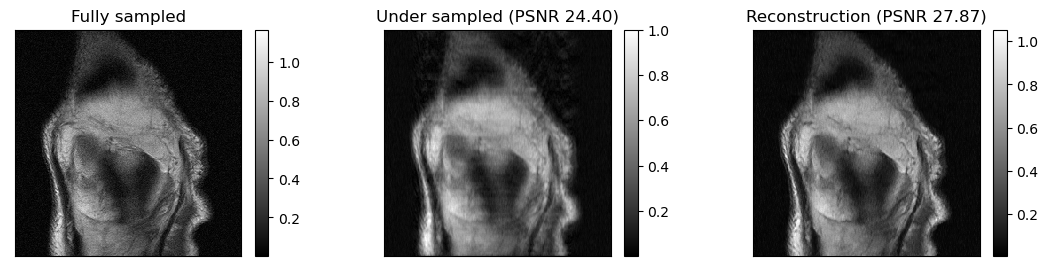

In [33]:
solver.visualize(test_loader, idx=100)